In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from h2o.automl import H2OAutoML
from h2o.estimators import H2ODeepLearningEstimator, H2OAutoEncoderEstimator
from h2o.frame import H2OFrame


# Inicializacion de h2o

In [ ]:
h2o.init(ip="172.25.197.59", port=54323)

Checking whether there is an H2O instance running at http://172.25.197.59:54323. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,18 mins 14 secs
H2O_cluster_timezone:,America/Lima
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,3 months and 15 days
H2O_cluster_name:,MyH2OCluster
H2O_cluster_total_nodes:,2
H2O_cluster_free_memory:,28.40 Gb
H2O_cluster_total_cores:,28
H2O_cluster_allowed_cores:,28
H2O_cluster_status:,"locked, healthy"


In [ ]:
# Prepare data for H2O

df_h2o = h2o.import_file(os.path.join(smb_dir, "processed", "yellow_tripdata_2016-03_processed.csv"))

KeyboardInterrupt: 

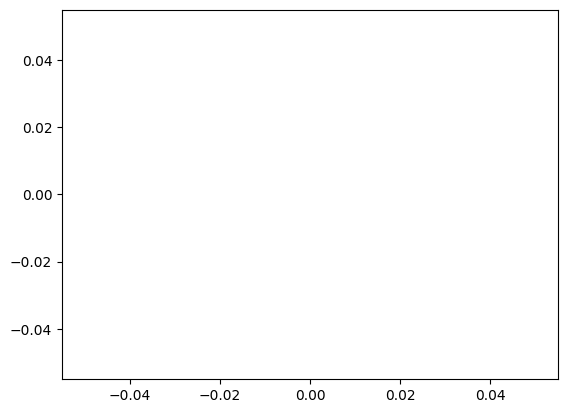

In [ ]:
# EDA: Distribution of trip duration and fare
df_h2o['trip_duration_min'].hist(bins=50)

In [ ]:
# EDA: Distribution of trip duration and fare
df_h2o['fare_amount'].hist(bins=50)

MemoryError: Unable to allocate 126. GiB for an array with shape (16967931842,) and data type float64

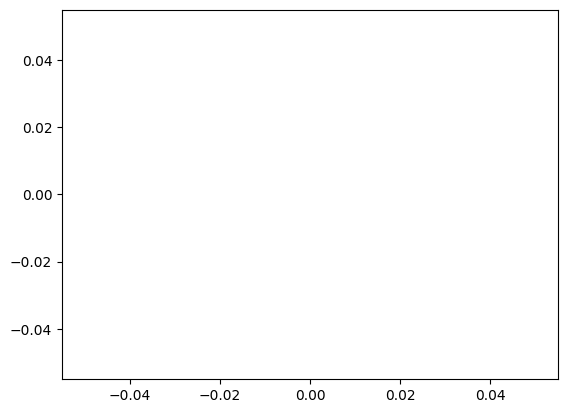

In [ ]:
sns.scatterplot(x='trip_duration_min', y='fare_amount', data=df_sample, alpha=0.2)
plt.title('Trip Duration vs Fare Amount')
plt.show()

In [ ]:
# Select features for modeling
feature_cols = [
    'passenger_count', 'trip_distance',
    'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude',
    'store_and_fwd_flag', 'payment_type',
    'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
    'improvement_surcharge'
]
target_duration = 'trip_duration_min'
target_fare = 'fare_amount'

# Split data
train, test = df_h2o.split_frame(ratios=[0.8], seed=42)

# Model 1: Predict trip duration
aml_duration = H2OAutoML(max_models=10, seed=1)
aml_duration.train(x=feature_cols, y=target_duration, training_frame=train)
duration_model = aml_duration.leader

# Model 2: Predict fare amount
aml_fare = H2OAutoML(max_models=10, seed=2)
aml_fare.train(x=feature_cols, y=target_fare, training_frame=train)
fare_model = aml_fare.leader

# Evaluate models
perf_duration = duration_model.model_performance(test)
perf_fare = fare_model.model_performance(test)
print('Trip Duration RMSE:', perf_duration.rmse())
print('Fare Amount RMSE:', perf_fare.rmse())

In [ ]:
# Example: Use these columns for EDA and modeling
# Features for modeling trip duration and fare:
feature_cols = [
    'passenger_count', 'trip_distance',
    'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude',
    'store_and_fwd_flag', 'payment_type',
    'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
    'improvement_surcharge'
]
target_duration = 'trip_duration_min'
target_fare = 'fare_amount'